In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # plotting geo data
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import autofeat
import osmnx as ox
import geopandas as gpd

from Own_imputers import PriorityGroupImputer
from OwnFeatEng import feature_engineering, feature_selection
from OwnDimRed import PCA_num

# Train

## Data

In [2]:
data = pd.read_csv("train.csv", header=0)
data = data.drop(columns=['is_promoted','sticker','price_drop_date'])

train, test = train_test_split(data,test_size=0.2, shuffle=True)

In [3]:
type_map = {
    'energy_label': 'category',
    'postcode': 'category',
    'advertiser' : 'category',
    'province' : 'category', 
    'house_type' : 'category',
    'subtype' : 'category',
    'new_building': 'bool'
}

house_map = {
    'Apartments & Flats': [
        'Appartement', 'Gelijkvloers app.', 'Duplex', 'Triplex', 'Dakappartement',
        'Penthouse', 'Serviceflat', 'Assistentie-appartement', 'Studio', 'Studio met slaaphoek', 
        'App. vrij beroep', 'Appartementsgebouw'
    ],
    'Single-Family Houses': [
        'Eengezinswoning', 'Woning', 'Villa', 'Villa-landhuis', 'Moderne villa',
        'Cottage', 'Bungalow', 'Koppelwoning', 'Koppelvilla', 'Hoekwoning', 'Rijwoning', 'Bel-étage', 'Burgerswoning'
    ],
    'Historical & Luxurious Homes': [
        'Herenhuis', 'Herenwoning', 'Uitzonderlijke woning', 'Kasteel', 'Pastorijwoning'
    ],
    'Farm & Rural Houses': [
        'Hoeve', 'Boerderij', 'Fermette', 'Chalet'
    ],
    'Mixed-Use & Unique Properties': [
        'Gemengd gebruik', 'Arbeiderswoning', 'Kangoeroewoning', 'Woonboot', 'Loft',
        'Split-level', 'Patio woning', 'Buitenverblijf', 'Vakantiewoning'
    ]
}

# Function to categorize houses
def categorize_house(house_type):
    for category, types in house_map.items():
        if house_type in types:
            return category
    return 'Other'

postcode_list = pd.read_csv("BE.txt", sep="\t", header=None)[[1,9,10]]
postcode_list.columns = ['postcode','lat','lon']
postcode_list['postcode']=postcode_list['postcode'].astype('category')
postcode_list = postcode_list.groupby('postcode', observed=False)[['lat','lon']].mean()

class preprocess:
    def __init__(self, postcode_source=None, type_map = {}):
        self.subtype_imputer = PriorityGroupImputer(target_cols=['subtype'], priority_groups = {1:['bedrooms_cat']}, strategy = 'mode')
        self.geo_imputer = PriorityGroupImputer(target_cols=['lat','lon'], priority_groups = {1:['postcode']}, strategy = 'external', data_source=postcode_source)
        self.clf_geo = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.clf_area = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.area_imputer = PriorityGroupImputer(target_cols=['area'], priority_groups = {1:['bedrooms_cat','house_type'], 2:['bedrooms_cat']}, strategy = 'median')
        self.ev_imputer_median = PriorityGroupImputer(target_cols=['energy_value'], priority_groups = {1:['energy_label','province']}, strategy = 'median', fallback=True)
        self.type_map = type_map
        self.belgium_polygon = ox.geocode_to_gdf("Belgium").geometry.iloc[0]
    
    def missing_checker(self, df):
            missing_values = round(df.isna().sum()/len(df)*100,2)
            missing_checker_df = df.isna()*1
            missing_checker_df = missing_checker_df.drop(columns=missing_values.index[missing_values==0].tolist())
            missing_checker_df = missing_checker_df.add_suffix('_miss')
            missing_checker_df = (missing_checker_df==1)
            return missing_checker_df

    def train(self, df):
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.fit_transform(df)

        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['lon'], df['lat']),
            crs="EPSG:4326"
            )
        in_belgium_mask = gdf.geometry.within(self.belgium_polygon)
        df['lat'] = np.where(in_belgium_mask, df['lat'], np.nan)
        df['lon'] = np.where(in_belgium_mask, df['lon'], np.nan)

        df = self.geo_imputer.fit_transform(df)

        # outliers_geo = self.clf_geo.fit_predict(df[['lat','lon']])
        # df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        # df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        
        # df = self.geo_imputer.transform(df)


        outliers_area = self.clf_area.fit_predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.fit_transform(df)
        
        df = self.ev_imputer_median.fit_transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

    def test(self, df):   
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.transform(df)
        
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['lon'], df['lat']),
            crs="EPSG:4326"
            )
        
        in_belgium_mask = gdf.geometry.within(self.belgium_polygon)
        df['lat'] = np.where(in_belgium_mask, df['lat'], np.nan)
        df['lon'] = np.where(in_belgium_mask, df['lon'], np.nan)

        df = self.geo_imputer.transform(df)
        
        # outliers_geo = self.clf_geo.predict(df[['lat','lon']])
        # df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        # df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        # df = self.geo_imputer.transform(df)

        outliers_area = self.clf_area.predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.transform(df)
        
        df = self.ev_imputer_median.transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='price'),train['price'], shuffle=True, test_size=0.2)
prep = preprocess(postcode_source=postcode_list, type_map=type_map)
X_train = prep.train(X_train).reset_index(drop=True)
X_val = prep.test(X_val).reset_index(drop=True)

In [5]:
X_train.columns

Index(['id', 'is_appartment', 'area', 'added_time', 'bedrooms', 'new_building',
       'postcode', 'lat', 'lon', 'advertiser', 'foto_amount', 'subtype',
       'energy_value', 'energy_label', 'province', 'bedrooms_cat',
       'house_type', 'area_miss', 'lat_miss', 'lon_miss', 'advertiser_miss',
       'subtype_miss', 'energy_value_miss', 'energy_label_miss'],
      dtype='object')

In [6]:
# fig = px.scatter_geo(X_train, lat='lat', lon='lon', scope='europe')
# fig.update_geos(showcountries=True, showcoastlines=True)
# fig.show()

In [7]:
# ev_imputer = KNNImputer(n_neighbors=10, weights='distance')
# imputed_data = ev_imputer.fit_transform(train[['energy_value','area','is_appartment','new_building', 'lat','lon']])
# # df_imputed = pd.DataFrame(imputed_data)
# train['energy_value']= pd.DataFrame(imputed_data)[0]

In [8]:
# plt.scatter(x=train['energy_value'],y=train['area'],c=missing_checker['energy_value'])
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim()

## Feature engineering

In [9]:
features_init = (['house_type',
             'bedrooms', 'area',
             'new_building', 'lat', 'lon', 'foto_amount',
             'energy_value', 
             'area_miss',  'energy_value_miss'])
# 'province', advertiser','advertiser_miss', 'lat_miss',  'subtype_miss', 'is_appartment', 

### loading geodata

In [10]:
np.random.seed(2)
ranint = np.random.randint(0, 17000, 5)
X_geo = X_train.sort_values('added_time').iloc[:5][['lat','lon','postcode','province']]
#X_geo['point'] = X_geo[['lat', 'lon']].to_records(index=False).tolist()

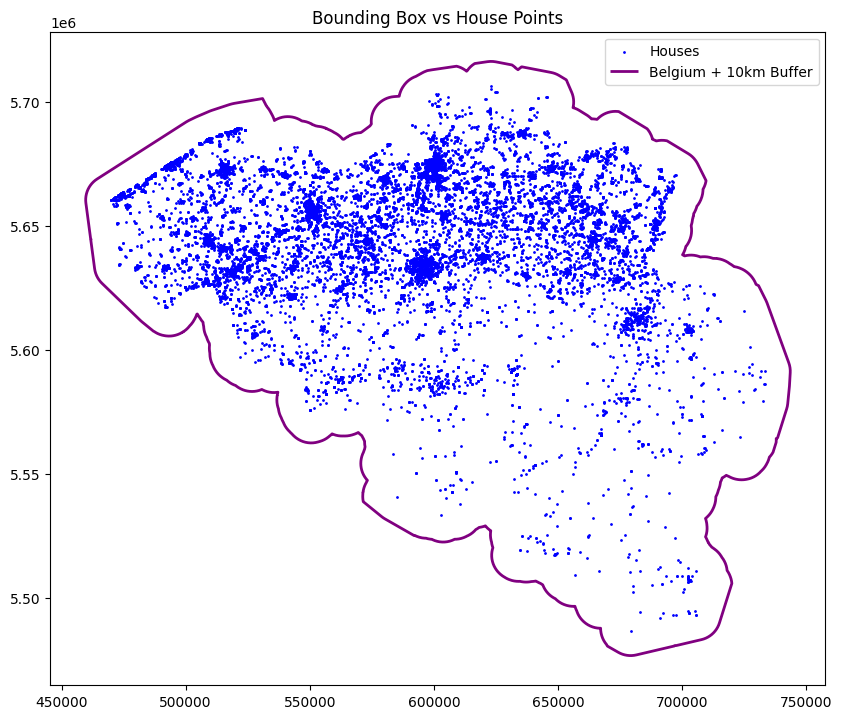

In [11]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, box

# Step 1: Convert to GeoDataFrame
gdf_houses = gpd.GeoDataFrame(
    X_train,
    geometry=[Point(xy) for xy in zip(X_train['lon'], X_train['lat'])],
    crs="EPSG:4326"
)

# Step 2: Project to UTM
utm_crs = gdf_houses.estimate_utm_crs()
gdf_houses = gdf_houses.to_crs(utm_crs)

# Step 3: Define bounding box with buffer
# bounds = gdf_houses.total_bounds  # (minx, miny, maxx, maxy)
# margin = 10000  # in meters
# bbox = (bounds[1] - margin, bounds[0] - margin, bounds[3] + margin, bounds[2] + margin)

# # Step 4: Create bounding box polygon
# bbox_polygon = box(bbox[1], bbox[0], bbox[3], bbox[2])  # (minx, miny, maxx, maxy)
# bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=gdf_houses.crs)

belgium = ox.geocode_to_gdf("Belgium").to_crs(utm_crs)
belgium_buffered = belgium.geometry.iloc[0].buffer(10000)
belgium_buffered_gdf = gpd.GeoDataFrame(geometry=[belgium_buffered], crs=gdf_houses.crs)

custom_polygon = gdf_houses.union_all().convex_hull.buffer(10000)
custom_polygon_gdf = gpd.GeoDataFrame(geometry=[custom_polygon], crs=gdf_houses.crs)

intersection_gdf = gpd.overlay(belgium_buffered_gdf, custom_polygon_gdf, how="intersection")

# Step 5: Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_houses.plot(ax=ax, color='blue', markersize=1, label='Houses')

#belgium_buffered_gdf.boundary.plot(
#     ax=ax, color='green', linewidth=2, label='Belgium + 10km Buffer'
# )
#custom_polygon_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bounding Box')

intersection_gdf.boundary.plot(
    ax=ax, color='purple', linewidth=2, label='Belgium + 10km Buffer'
)
plt.legend()
plt.title("Bounding Box vs House Points")
plt.show()

intersection_gdf_espg4326 = intersection_gdf.to_crs("EPSG:4326").geometry.iloc[0]

In [12]:
intersection_gdf.area/1e6

0    40475.877991
dtype: float64

In [13]:
40408.73006/313.65484905459326

128.83183595534544

In [14]:
# 1 priority
useamenity = ["restaurant", "fast_food", "cafe", "bar", "pub", 'nightclub' ,'stripclub', 'internet_cafe',
                "college", 'kindergarten', 'library', 'research_institute', 'music_school' , 'school', 'university', 'driving_school', 'traffic_park', 'driver_training',
                'bus_station', 'taxi',
                'bank',
                'clinic', 'dentist ' ,'doctors','hospital','nursing_home', 'pharmacy', 'social_facility', 'veterinary',
                'arts_centre','brothel','casino','cinema','community_centre','conference_centre','events_venue','exhibition_centre','fountain','gambling','music_venue',
                'planetarium','social_centre', 'stage', 'theatre',
                'courthouse', 'fire_station' ,'police', 'prison', 'townhall',
                'crematorium','funeral_hall','grave_yard','mortuary',
                'charging_station', 'fuel']
area_calc = []
tag_amenity = {'amenity': True}
tag_shop = {'shop': True}
tag_leisure = {'leisure': True}
tag_tourism = {'tourism': True}


In [15]:
# gdf_tourism = ox.features.features_from_polygon(intersection_gdf_espg4326, tags=tag_tourism)[['geometry','tourism']]
# print(gdf_tourism.head())

In [16]:
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_tourism.plot(
#     ax=ax, color='purple', markersize=1
# )
# gdf_houses.to_crs(gdf_tourism.crs).plot(ax=ax, color='blue', markersize=1, label='Houses')
# plt.show()

In [17]:
# gdf_tourism.to_file("gdf_tourism.gpkg", driver="GPKG")

In [18]:
valid_in_any_group = (
    gdf_tourism.groupby('amenity')
    .apply(lambda g: ~g.isna().any(), include_groups=False) 
    .any(axis=0)                       
)

NameError: name 'gdf_tourism' is not defined

In [ ]:
valid_in_any_group[valid_in_any_group].index.to_list()

['geometry',
 'tourism',
 'information',
 'name',
 'website',
 'operator',
 'addr:housenumber',
 'addr:street',
 'addr:city',
 'addr:postcode',
 'historic',
 'wikimedia_commons',
 'wikipedia',
 'start_date',
 'wikidata',
 'network',
 'network:wikidata',
 'ref:hoppin_column',
 'OnroerendErfgoed:criteria',
 'addr:country',
 'building',
 'heritage:operator',
 'heritage:website',
 'ref:OnroerendErfgoed',
 'food',
 'denomination',
 'religion']

### features from geodata


In [19]:
from OwnFeatEng import add_geo_features_optimized

In [20]:
gdf_leisure = gpd.read_file('gdf_leisure.gpkg')

In [ ]:
leisure_features = gdf_leisure.groupby('leisure')['geometry'].count()[(gdf_leisure.groupby('leisure')['geometry'].count()>25)]

In [21]:
X_try  = X_train.iloc[:100]
gdf_houses_espg4326 = gpd.GeoDataFrame(
    X_try,
    geometry=[Point(xy) for xy in zip(X_try['lon'], X_try['lat'])],
    crs="EPSG:4326"
)
park_features =add_geo_features_optimized(gdf_houses_espg4326, gdf_leisure, 'leisure', 'park', [500], 10000, True)

Building spatial index...


100%|██████████| 100/100 [00:01<00:00, 86.04it/s]


In [22]:
park_features

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,lon_miss,advertiser_miss,subtype_miss,energy_value_miss,energy_label_miss,geometry,closest_leisure*park,mean_leisure*park_500,count_leisure*park_500,mean_area_leisure*park_500
0,tr17909,True,118.00,141804735,2.0,True,9100,51.168970,4.138898,Quares Waasland,...,False,False,False,False,False,POINT (4.1389 51.16897),84.958304,269.774813,8.0,2754.254162
1,tr1757,False,233.00,138480338,3.0,False,1790,50.913280,4.113100,NB-Projects,...,False,False,False,True,True,POINT (4.1131 50.91328),540.837648,0.000000,0.0,0.000000
2,tr14062,False,305.00,130785522,5.0,False,9660,50.797450,3.763282,Immo Nobels,...,False,False,False,False,False,POINT (3.76328 50.79745),600.435815,0.000000,0.0,0.000000
3,tr12171,True,89.00,143102315,2.0,False,3500,50.929280,5.352139,Vastgoed Valkenborgh,...,False,False,False,False,False,POINT (5.35214 50.92928),176.311623,368.811885,7.0,3367.268540
4,tr23298,True,30.00,137036786,0.0,False,8420,51.300514,3.078139,Habitas,...,False,False,False,True,True,POINT (3.07814 51.30051),267.202183,310.841158,8.0,1422.578446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,tr1588,False,346.00,142141726,5.0,False,3890,50.722160,5.134336,Geert Pierco Vastgoed,...,False,False,False,False,False,POINT (5.13434 50.72216),2514.913718,0.000000,0.0,0.000000
96,tr9652,True,94.22,139479725,2.0,False,4800,50.582960,5.873180,Flech'Euro,...,False,False,False,True,True,POINT (5.87318 50.58296),763.276874,0.000000,0.0,0.000000
97,tr8766,False,242.00,133067707,3.0,False,9700,50.847450,3.668520,NB-Projects,...,False,False,False,True,True,POINT (3.66852 50.84745),2576.403035,0.000000,0.0,0.000000
98,tr3689,True,80.00,141788639,2.0,True,8710,50.911560,3.370667,Vastgoed Canniere,...,False,False,False,True,True,POINT (3.37067 50.91156),757.585414,0.000000,0.0,0.000000


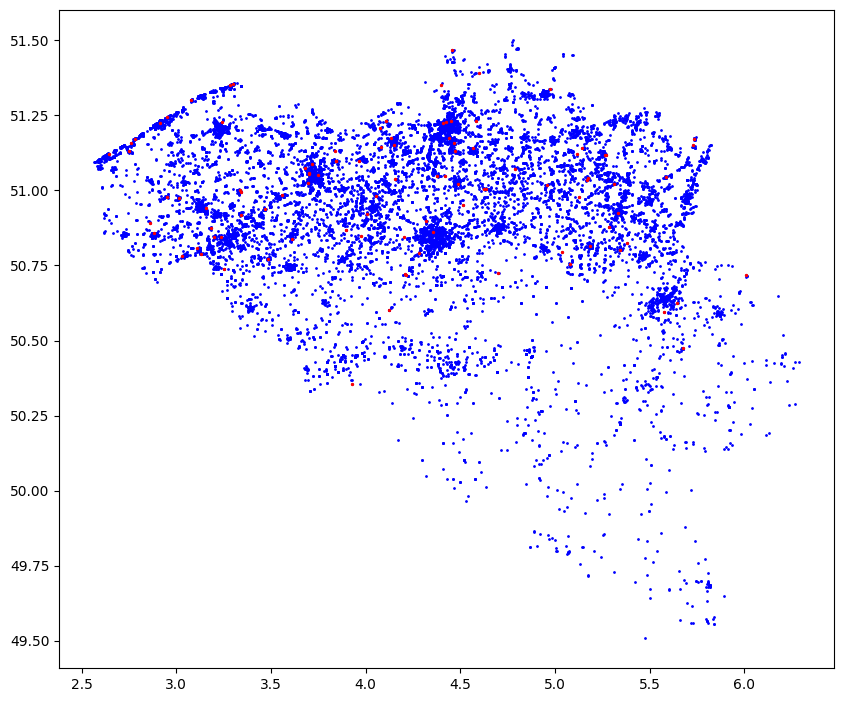

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
# gdf_tourism.plot(
#     ax=ax, color='purple', markersize=1
# )
gdf_houses.to_crs(park_features.crs).plot(ax=ax, color='blue', markersize=1, label='Houses')
park_features.plot(ax=ax, color='red', markersize=2, label='Houses')

plt.show()

In [113]:
park_features_opt = add_geo_features_optimized(gdf_houses_espg4326, gdf_leisure, 'leisure', 'park', [500,1000,2000], 10000)

Building spatial index...


C:\Users\iskan\AppData\Local\Temp\ipykernel_43160\1926336660.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '275.2542457048024' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  houses_gdf.at[i, f'closest_{tag}*{type}'] = distances.min()
100%|██████████| 100/100 [00:01<00:00, 86.73it/s]


In [119]:
park_features_opt

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,closest_leisure*park,mean_leisure*park_500,count_leisure*park_500,mean_area_leisure*park_500,mean_leisure*park_1000,mean_leisure*park_2000,count_leisure*park_1000,count_leisure*park_2000,mean_area_leisure*park_1000,mean_area_leisure*park_2000
0,tr19933,False,486.00,122183609,10.0,False,3660,51.044200,5.586730,Consimmo Vastgoed,...,275.254246,275.254246,1,7875.836589,275.254246,711.185635,1,2,7875.836589,3994.909376
1,tr26770,False,325.00,142841858,7.0,False,8620,51.130547,2.752135,Nova Vastgoed,...,346.531137,419.343861,4,14719.237371,538.681999,738.769023,8,10,8921.852441,17610.448337
2,tr3613,False,206.00,132458292,4.0,False,2540,51.157000,4.468900,Heylen Vastgoed - Mortsel,...,430.400149,430.400149,1,12052.908142,655.020477,1314.743651,4,29,4956.179888,25799.312875
3,tr14592,False,175.00,138781913,3.0,False,1500,50.720258,4.209507,Living Stone Halle,...,63.618506,246.764841,3,2081.056763,446.204437,1143.825227,5,14,12519.396173,12261.703706
4,tr12039,True,81.00,141544519,2.0,False,9032,51.087603,3.718443,Makelaarshuys,...,125.120298,274.401076,4,15336.297233,530.781695,1168.615539,10,35,14815.435480,18851.476944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,tr23683,False,218.00,141204493,5.0,False,8880,50.873143,3.182343,ERA @t Home (Geluwe),...,1506.126636,NaN,0,NaN,NaN,1506.126636,0,1,NaN,467.673732
96,tr5928,False,192.00,81955386,0.0,False,3545,50.977740,5.126180,Hillewaere Hasselt,...,1582.336338,NaN,0,NaN,NaN,1582.336338,0,1,NaN,1846.515437
97,tr4262,False,199.08,139464616,3.0,False,9170,51.232440,4.107350,NB-Projects,...,1276.614692,NaN,0,NaN,NaN,1276.614692,0,1,NaN,3384.522414
98,tr17973,False,150.00,141276159,3.0,False,8800,50.940410,3.157904,Hectaar NV,...,1480.024485,NaN,0,NaN,NaN,1637.610155,0,6,NaN,47163.383965


### New own features

In [9]:
def SpecialTransform(df):
    X = pd.DataFrame()
    X['area_bed'] = df.area/(df.bedrooms+1)
    X['area_foto'] = df.area/df.foto_amount
    X.loc[df['foto_amount'] == 0, 'area_foto'] = 0
    X['ev_area'] = df.energy_value/df.area
    X['miss_tot'] = df.energy_value_miss*1 + df.area_miss*1 + df.advertiser_miss*1 + df.lat_miss*1 + df.subtype_miss*1
    return X

In [10]:
new_cols = SpecialTransform(X_train).columns.to_list()
X_train = X_train.join(SpecialTransform(X_train))
X_val = X_val.join(SpecialTransform(X_val))

In [ ]:
cl_range = list(range(20,101,20)) + list(range(150,301,50))
feateng = feature_engineering(targets=['area', 'bedrooms','energy_value','area_bed','ev_area','area_foto'],
                              transform_type=['median'],
                              comp_type=['diff','frac'],
                              groups=['province','house_type'],
                              features=['lat','lon'],
                              cl_name='clt',
                              clustering=True, 
                              cluster_range=cl_range)

feateng_density = feature_engineering(targets=['area'],
                              transform_type=['count'],
                              comp_type=None,
                              groups=['province','house_type'],
                              features=['lat','lon'],
                              cl_name='clt',
                              clustering=False, 
                              cluster_range=cl_range)

X_train_new = feateng.train(X_train)
X_val_new = feateng.test(X_val)


X_train_new = feateng_density.train(X_train_new)
X_val_new = feateng_density.test(X_val_new)

In [13]:
features_new = features_init + X_train_new.columns.to_list()[25:]
print(len(features_new))

232


### Feature selection on correlation

In [14]:
def getnum(df):
    logic = (df.dtypes=='float64') | (df.dtypes=='float32') | (df.dtypes=='float16')
    num_features = df.dtypes[logic].index.to_list()
    other_features = df.dtypes[~logic].index.to_list()
    return num_features, other_features

In [ ]:
numcols, othcols = getnum(X_train_new)

In [16]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Spearman Correlation Matrix')
# plt.show()

In [ ]:
numcols, othcols = getnum(X_train_new)
catcols = ['new_building',
 'advertiser',
 'subtype',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
 'subtype_miss',
 'energy_label_miss',
 'clt20',
 'clt40',
 'clt60',
 'clt80',
 'clt100',
 'clt150',
 'clt200',
 'clt250',
 'clt300']

numcols = numcols + (
['miss_tot',
 'area-clt20-count',
 'area-clt40-count',
 'area-clt60-count',
 'area-clt80-count',
 'area-clt100-count',
 'area-clt150-count',
 'area-clt200-count',
 'area-clt250-count',
 'area-clt300-count',
 'area-province-count',
 'area-house_type-count' ])

In [19]:
only_cor = feature_selection()
selected, _ = only_cor.select(X_train_new[numcols])

In [ ]:
# items_to_remove = {'index', 'id', 'is_appartment', 'added_time', 'postcode', 'energy_label', 'province', 'bedrooms_cat', 'lon_miss' ,'energy_value_miss'}
# othcols = [x for x in othcols if x not in items_to_remove]
features_filt = catcols+selected

### MI scores

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# mi_scores = make_mi_scores(X_train_new_new[features_new],y_train.reset_index(drop=True))
# plot_mi_scores(mi_scores)

### Autofeat

In [74]:
X_train_new = X_train_new[catcols + numcols]
X_val_new = X_val_new[catcols + numcols]

In [ ]:
categorical_cols=['house_type', 'lat_miss',  'clt20', 'clt40', 'clt60', 'clt80', 'clt100', 'clt150', 'clt200', 'clt250', 'clt300']
feateng_cols=['area', 'energy_value', 'bedrooms', 'foto_amount']

autofeatures = autofeat.AutoFeatRegressor(feateng_cols=feateng_cols, featsel_runs=2)
X_train_feat = autofeatures.fit_transform(X_train_new[feateng_cols], np.log(y_train.reset_index(drop=True))).drop(columns=feateng_cols)
X_val_feat = autofeatures.transform(X_val_new[feateng_cols]).drop(columns=feateng_cols)

X_train_new = X_train_new.join(X_train_feat)
X_val_new = X_val_new.join(X_val_feat)

## Dimensionality Reduction

### PCA

In [ ]:
# pca_own = PCA_num(n_components=100)
# X_train_red = pca_own.fit_transform(X_train_new_new)

## Model

### KNN

In [100]:
# X_train, y_train = train[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy(),train['price'].copy()

# X_train_encoded = pd.get_dummies(X_train, columns=['house_type'])

# scaler = StandardScaler()
# X_train_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_train_encoded[['area','lat','lon','energy_value','foto_amount']])

In [101]:
# scores_KNN = []
# for i in range(2,60,2):
#     neigh_model = KNeighborsRegressor(n_neighbors=i, weights='distance')
#     scores_KNN.append(cross_val_score(neigh_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')*-1)

# scores_KNN = pd.DataFrame(scores_KNN)
# plt.scatter((scores_KNN.index+1)*2, scores_KNN.apply(np.mean, axis=1))

In [102]:
# neigh_model_final = KNeighborsRegressor(n_neighbors=14, weights='distance')
# neigh_model_final.fit(X_train_encoded,y_train)

### XGBoost

In [76]:
#X_train, X_val, y_train, y_val = train_test_split(train[features],train['price'], shuffle=False, test_size=0.2)

dtrain = xgb.DMatrix(X_train_new, label=np.log(y_train.reset_index(drop=True)), enable_categorical=True)
dval = xgb.DMatrix(X_val_new,label=np.log(y_val.reset_index(drop=True)), enable_categorical=True)

evallist = [(dval, 'val')]

param_xgb = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10,}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=2000
)
RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
print(RMSE)

109499.32399963765


In [69]:
scores = xgb_regressor.get_score(importance_type='gain')
selected_scr, _ = select_features_with_importance(X_train_new[numcols], scores, threshold=0.9)

In [71]:
features_filt_scr = othcols+selected_scr

In [78]:
def featsel(xgb_regressor = xgb_regressor):
    df_scores = pd.DataFrame.from_dict(xgb_regressor.get_score(importance_type='gain'), orient='index', columns=['gain'])
    df_scores = df_scores.join(pd.DataFrame.from_dict(xgb_regressor.get_score(importance_type='cover'), orient='index', columns=['cover']))
    df_scores['gain_rank']=df_scores['gain'].rank(method='min', ascending=False).astype(int)
    df_scores['cover_rank']=df_scores['cover'].rank(method='min', ascending=False).astype(int)
    df_scores['overall_rank'] = df_scores['gain_rank']+df_scores['cover_rank']
    df_scores['overall_rank'] = df_scores['overall_rank'].rank(method='min', ascending=True).astype(int)
    df_scores=df_scores.sort_values(by='overall_rank', ascending=True)
    features = df_scores.index[:-5]
    return features

In [ ]:
features_new_new = features_new
len(features_new)

232

In [78]:
dtrain = xgb.DMatrix(X_train_new[features_new], label=np.log(y_train.reset_index(drop=True)), enable_categorical=True)
dval = xgb.DMatrix(X_val_new[features_new],label=np.log(y_val.reset_index(drop=True)), enable_categorical=True)

evallist = [(dval, 'val')]

param_xgb = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10,}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=1000
)
RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
print(RMSE)

# features_new_new=featsel(xgb_regressor)
# print(len(features_new_new))

104458.19050112544


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

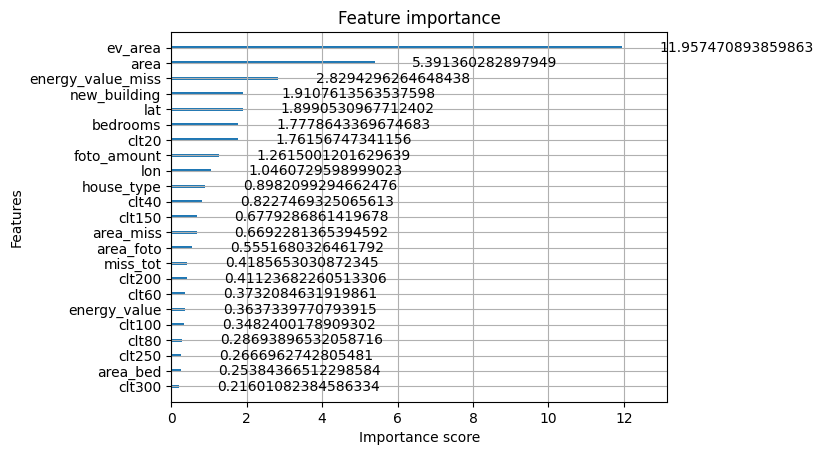

In [27]:
xgb.plot_importance(xgb_regressor, importance_type='gain')

# Test

## Data

In [25]:
# test = pd.read_csv("test.csv", header=0)
test = test.reset_index()
# test = test.drop(columns=['is_promoted','sticker','price_drop_date'])
test['energy_label'] = test['energy_label'].astype('category')
test['new_building'] = test['new_building'].astype('bool')
test['postcode'] = test['postcode'].astype('category')

test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
test['house_type'] = test['subtype'].apply(categorize_house)

## KNN

In [ ]:
# X_test = test[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy()

# X_test_encoded = pd.get_dummies(X_test, columns=['house_type'])

# scaler = StandardScaler()
# X_test_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_test_encoded[['area','lat','lon','energy_value','foto_amount']])
# X_test_encoded.isna().apply(sum)
# y_test = test['price'].copy()
# y_pred_test = neigh_model_final.predict(X_test_encoded)

## XGBoost

## Error bars

In [615]:
mean_error_1=(y_pred_test/y_test-1).mean()
error_bound_1 = (y_pred_test/y_test-1).std()/len(y_pred_test)**(1/2)*1.96

mean_error_2=abs(y_pred_test/y_test-1).mean()
error_bound_2 = abs(y_pred_test/y_test-1).std()/(len(y_pred_test)**(1/2))*1.96

mean_error_3=((y_pred_test-y_test)**2).mean()**(1/2)
error_bound_3 = abs(y_pred_test-y_test).std()/(len(y_pred_test)**(1/2))*1.96

# Submission metrics

In [510]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_1-error_bound_1)
y_pred_final['upper']=y_pred_test*(1-mean_error_1+error_bound_1)
y_pred_final['pred']=y_pred_test*(1-mean_error_1)

y_pred_final.to_csv(f"xgb_simple_1.csv", index=False)

In [513]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_2-error_bound_2)
y_pred_final['upper']=y_pred_test*(1+mean_error_2+error_bound_2)
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_2.csv", index=False)

In [512]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=np.maximum(y_pred_test-mean_error_3-error_bound_3,0)
y_pred_final['upper']=y_pred_test+mean_error_3+error_bound_3
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_3.csv", index=False)